In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow

from sklearn.metrics import  make_scorer
from lightgbm import LGBMRanker, LGBMClassifier #, __version__
from lightgbm import plot_importance


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='macro')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='macro') #average = 'weighted')



idx = pd.IndexSlice
import pylab as plt


In [5]:
# import sys
# sys.path.append('../')

# # from propmatch.mlflowcli import log_mlflow
from model import get_model

## Load Data

In [6]:
files = Path('./data/candidates_georef_v4').glob('*.parquet')

In [7]:
data = pd.concat((pd.read_parquet(str(f)) for f in files))

In [8]:
data.columns

Index(['sale_id', 'trxn_id', 'trxn_price', 'listing_price', 'correct_sale_id',
       'lottype_cat', 'unittype_cat', 'spatial', 'days', 'price_diff',
       'price_pct_diff', 'partial_street_score', 'partial_unit_score', 'total',
       'same_zipcode', 'listing_unit', 'closing_unit', 'listing_street',
       'closing_street', 'trxn_zip', 'trxn_city', 'trxn_state', 'listing_zip',
       'listing_city', 'area_id', 'x', 'y', 'distance', 'azimuth',
       'building_in_10', 'same_complex', 'same_building_id', 'same_block',
       'same_bin', 'same_building_bbl', 'same_bbl', 'same_unittype',
       'same_unit', 'candidates', 'trxn_candidates', 'status'],
      dtype='object')

In [9]:
print(f'Total pairs: {len(data):,d}, matched: {data["correct_sale_id"].nunique():,d} ({data["correct_sale_id"].nunique()/len(data):.2%})')

Total pairs: 1,075,485, matched: 3,646 (0.34%)


In [10]:
data['match'] = (data['sale_id'] == data['correct_sale_id']).astype(int)

In [11]:
data.isnull().mean().sort_values()

trxn_city               0.000000
trxn_candidates         0.000000
same_unit               0.000000
same_unittype           0.000000
same_bbl                0.000000
same_building_bbl       0.000000
same_bin                0.000000
same_block              0.000000
same_building_id        0.000000
same_complex            0.000000
trxn_state              0.000000
trxn_zip                0.000000
closing_street          0.000000
closing_unit            0.000000
match                   0.000000
trxn_price              0.000000
lottype_cat             0.000000
listing_unit            0.000010
candidates              0.000010
listing_price           0.000010
spatial                 0.000010
price_diff              0.000010
building_in_10          0.000010
same_zipcode            0.000010
distance                0.000010
y                       0.000010
azimuth                 0.000010
area_id                 0.000010
listing_city            0.000010
listing_zip             0.000010
price_pct_

## Features

In [12]:
features = ['spatial', 'days', 'price_pct_diff', 
            'partial_unit_score',
            "partial_street_score",
            'same_unit',
            'same_building_id', 
            'same_bin',
            'same_complex',
            "candidates",
            "same_zipcode",
            "building_in_10",
#             "closing_candidates", 
            'same_unittype', 
#             'same_rd_normalized_unit',
            'unittype_cat',
            'x', 'y', 'distance', 'azimuth'
            ]

ycol = 'match'

In [13]:
X = data[features]
y = data[ycol]

In [14]:
bool_cols = ['same_unit', 'same_building_id', 'same_bin', 'same_complex', 'same_zipcode', 'building_in_10', 'same_unittype']
X[bool_cols] = X[bool_cols].astype(bool).astype(int)

/var/folders/v2/l685f8rj7jn4flt11pny4lsr0000gq/T/ipykernel_74961/1724854506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols] = X[bool_cols].astype(bool).astype(int)


In [15]:
X.select_dtypes('object')

,unittype_cat
0,Coop
1,Coop
2,Coop
3,Coop
4,Coop
...,...
3325,Coop
3326,Coop
3327,Coop
3328,Coop


## Validation Set

In [63]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=2024, stratify=y)

In [64]:
f"Training set size {len(ytrain):,d}, matched: {ytrain.mean():.2%}"

'Training set size 967,936, matched: 0.34%'

In [65]:
f"Validation set size {len(yval):,d}, matched: {yval.mean():.2%}"

'Validation set size 107,549, matched: 0.34%'

## Model

In [56]:
params = {'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [57]:
model = get_model(LGBMClassifier).set_params(**params)
# model.steps = model.steps[1:]

In [58]:
# model = model.steps[1][1]

In [59]:
scoring={'average_precision': average_precision_scorer,
         'roc_auc': roc_auc_scorer}

In [60]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [61]:
# X

In [66]:
metrics = cross_validate(model, Xtrain, ytrain, 
                         cv=skf, return_train_score=False,
                         scoring=scoring)

In [69]:
pd.DataFrame(metrics)[['test_average_precision','test_roc_auc']].agg(['mean', 'std']).T

,mean,std
test_average_precision,0.560112,0.030194
test_roc_auc,0.908709,0.008766


## Validation Performance

In [71]:
model.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ut',
                                                  LeaveOneOutEncoder(cols=['unittype_cat'],
                                                                     handle_unknown='ignore',
                                                                     sigma=0.05),
                                                  ['unittype_cat'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.5013544317317782,
                                min_child_samples=51, min_child_weight=1e-05,
                                num_leaves=21, reg_alpha=0.1, reg_lambda=5,
                                subsample=0.4301443471481221))])

In [72]:
y_pred = model.predict(Xval)

In [78]:
print(f"""
On validation
- precision: {precision_score(yval, y_pred):.4f}
- recall: {recall_score(yval, y_pred):.4f}
""")


On validation
- precision: 0.6899
- recall: 0.8411



## Plots

In [83]:
y_proba = model.predict_proba(Xval)[:, 1]

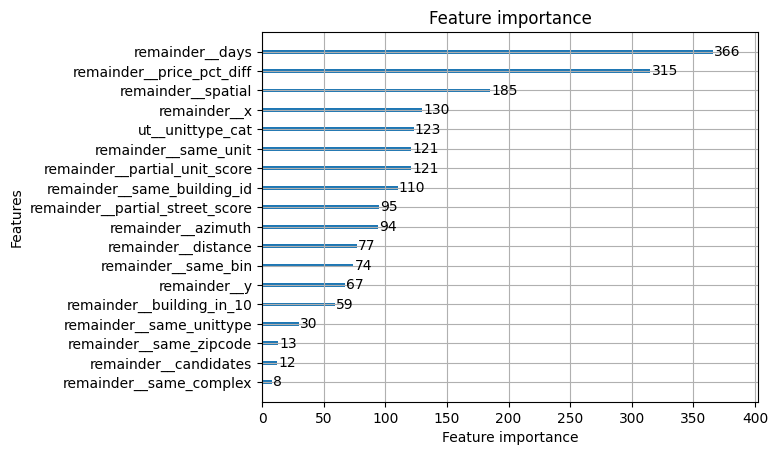

In [81]:
plot_importance(model.steps[1][1]); 
# plot_importance(m); 

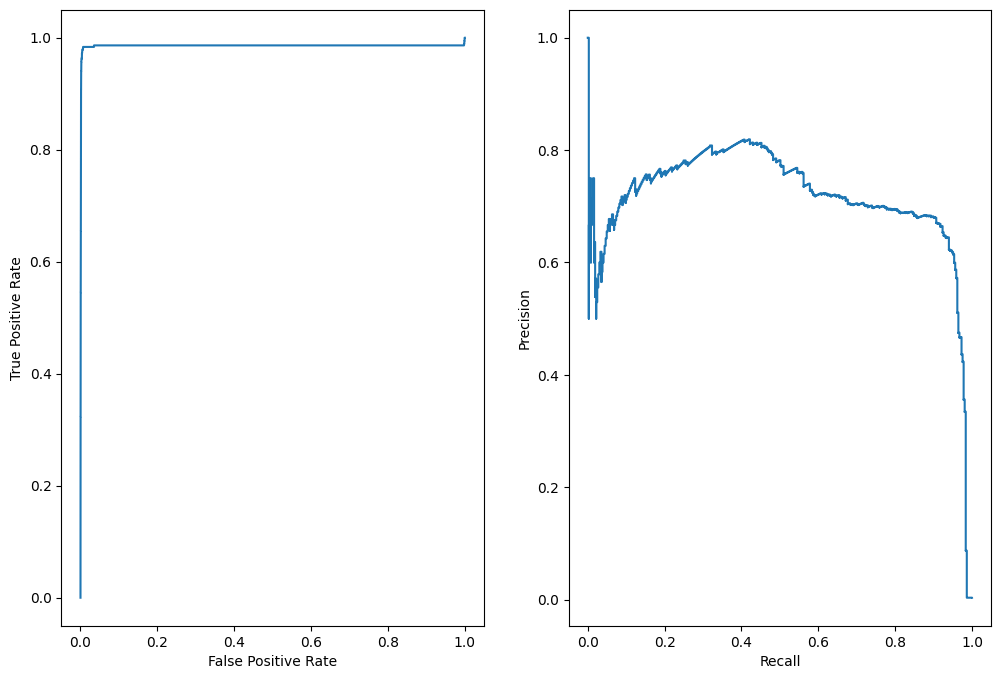

In [85]:
fpr, tpr, _ = roc_curve(yval, y_proba, pos_label=1)
prec, recall, _ = precision_recall_curve(yval, y_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### Threshold Curve

In [94]:
prec, recall, step = precision_recall_curve(yval, y_proba, pos_label=1)

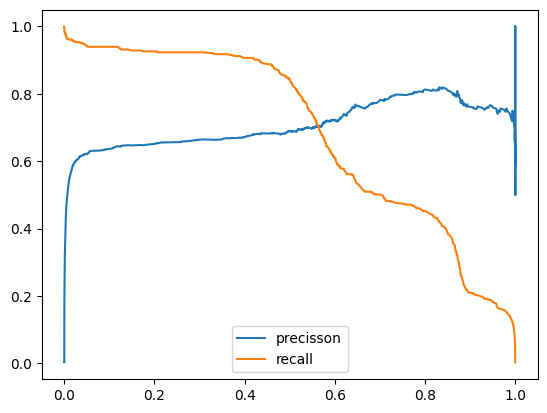

In [96]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();

### Calibration

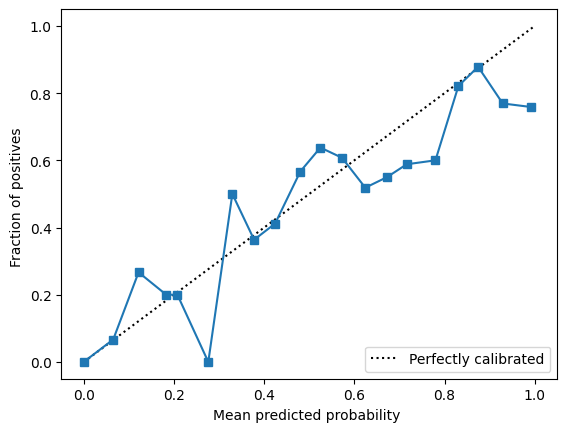

In [98]:
prob_true, prob_pred = calibration_curve(yval, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()